# 01 - Environment Exploration

**Goal:** Understand the Pusher environment deeply before implementing any learning algorithms.

**Time:** 2-3 hours

**What you'll learn:**
- What each observation dimension represents
- What each action controls
- How joints affect the fingertip position
- What makes this task challenging
- Baseline performance metrics

**Why this matters:**
You can't train an agent effectively if you don't understand the environment. This exploration will give you intuition that guides your RL implementation.

---

## 1. Setup

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import gymnasium as gym
from tqdm import tqdm
from IPython.display import display, Markdown, HTML
import sys
import os

# Add src to path
sys.path.append(os.path.abspath('../src'))

# Plotting setup
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print("✅ Libraries imported")

✅ Libraries imported


## 2. Understanding the Observation Space

The Pusher environment has a 23-dimensional observation space. Let's break it down.

In [2]:
# Create environment
env = gym.make("Pusher-v5")

# Get one observation
obs, info = env.reset(seed=42)

print("📊 Observation Space Breakdown")
print("=" * 80)
print(f"Total dimensions: {len(obs)}\n")

# Define what each dimension means
observation_description = {
    'Joint Positions': (0, 7, [
        'shoulder_pan_joint',
        'shoulder_lift_joint', 
        'upper_arm_roll_joint',
        'elbow_flex_joint',
        'forearm_roll_joint',
        'wrist_flex_joint',
        'wrist_roll_joint'
    ]),
    'Joint Velocities': (7, 14, [
        'shoulder_pan_velocity',
        'shoulder_lift_velocity',
        'upper_arm_roll_velocity',
        'elbow_flex_velocity',
        'forearm_roll_velocity',
        'wrist_flex_velocity',
        'wrist_roll_velocity'
    ]),
    'Fingertip Position': (14, 17, ['x', 'y', 'z']),
    'Object Position': (17, 20, ['x', 'y', 'z']),
    'Goal Position': (20, 23, ['x', 'y', 'z'])
}

# Display breakdown
for category, (start, end, names) in observation_description.items():
    print(f"\n{category} (indices {start}-{end-1}):")
    values = obs[start:end]
    for name, value in zip(names, values):
        print(f"  [{start + names.index(name):2d}] {name:25s}: {value:8.4f}")

print("\n" + "=" * 80)

📊 Observation Space Breakdown
Total dimensions: 23


Joint Positions (indices 0-6):
  [ 0] shoulder_pan_joint       :   0.0000
  [ 1] shoulder_lift_joint      :   0.0000
  [ 2] upper_arm_roll_joint     :   0.0000
  [ 3] elbow_flex_joint         :   0.0000
  [ 4] forearm_roll_joint       :   0.0000
  [ 5] wrist_flex_joint         :   0.0000
  [ 6] wrist_roll_joint         :   0.0000

Joint Velocities (indices 7-13):
  [ 7] shoulder_pan_velocity    :   0.0026
  [ 8] shoulder_lift_velocity   :   0.0029
  [ 9] upper_arm_roll_velocity  :  -0.0037
  [10] elbow_flex_velocity      :  -0.0005
  [11] forearm_roll_velocity    :  -0.0013
  [12] wrist_flex_velocity      :   0.0043
  [13] wrist_roll_velocity      :   0.0014

Fingertip Position (indices 14-16):
  [14] x                        :   0.8210
  [15] y                        :  -0.6000
  [16] z                        :   0.0000

Object Position (indices 17-19):
  [17] x                        :   0.6402
  [18] y                        :  -0

### 📏 Initial Configuration Analysis

In [3]:
# Extract key positions
fingertip_pos = obs[14:17]
object_pos = obs[17:20]
goal_pos = obs[20:23]

# Calculate distances
dist_finger_to_object = np.linalg.norm(fingertip_pos - object_pos)
dist_object_to_goal = np.linalg.norm(object_pos - goal_pos)
dist_finger_to_goal = np.linalg.norm(fingertip_pos - goal_pos)

print("📏 Initial Spatial Relationships:")
print("=" * 80)
print(f"Fingertip position: {fingertip_pos}")
print(f"Object position:    {object_pos}")
print(f"Goal position:      {goal_pos}")
print()
print(f"Distance (fingertip → object): {dist_finger_to_object:.4f} meters")
print(f"Distance (object → goal):      {dist_object_to_goal:.4f} meters")
print(f"Distance (fingertip → goal):   {dist_finger_to_goal:.4f} meters")
print()
print(f"✅ Success threshold: 0.05 meters (5cm)")
print(f"📊 Initial object-to-goal distance: {dist_object_to_goal:.4f} meters")
print("=" * 80)

📏 Initial Spatial Relationships:
Fingertip position: [ 0.821 -0.6    0.   ]
Object position:    [ 0.64024894 -0.3217468  -0.275     ]
Goal position:      [ 0.45  -0.05  -0.323]

Distance (fingertip → object): 0.4310 meters
Distance (object → goal):      0.3352 meters
Distance (fingertip → goal):   0.7379 meters

✅ Success threshold: 0.05 meters (5cm)
📊 Initial object-to-goal distance: 0.3352 meters


### 🎯 Key Insight

Write your observations here:
- Is the object close to the goal initially?
    - The object maintains a relative distance of 0.3 meter. My judgement is that is not that far
- Is the fingertip close to the object?
    - The fingertip is not very close to the object
- What needs to happen for success?
    - We need to learn how to optimally manuover the arm to move the object

## 3. Understanding the Action Space

Let's test each joint individually to see what it controls.

In [4]:
print("🔧 Action Space Information")
print("=" * 80)
print(f"Action dimensions: {env.action_space.shape[0]}")
print(f"Action range: [{env.action_space.low[0]:.1f}, {env.action_space.high[0]:.1f}]")
print()
print("Each action is a torque applied to one joint.")
print("Positive values cause rotation in one direction.")
print("Negative values cause rotation in the opposite direction.")
print("=" * 80)

🔧 Action Space Information
Action dimensions: 7
Action range: [-2.0, 2.0]

Each action is a torque applied to one joint.
Positive values cause rotation in one direction.
Negative values cause rotation in the opposite direction.


### Test Individual Joints (Optional Interactive)

⚠️ **Note:** This will open a visualization window. If you're working remotely or prefer to skip visualization, set `test_joints = False`.

In [6]:
test_joints = True  # Set to True if you want to see visualizations

if test_joints:
    print("Testing each joint individually...")
    print("Watch the visualization window to see what each joint controls.\n")
    
    joint_names = [
        'shoulder_pan', 'shoulder_lift', 'upper_arm_roll',
        'elbow_flex', 'forearm_roll', 'wrist_flex', 'wrist_roll'
    ]
    
    env_visual = gym.make("Pusher-v5", render_mode="human")
    
    for joint_idx, joint_name in enumerate(joint_names):
        print(f"Testing Joint {joint_idx}: {joint_name}")
        obs, _ = env_visual.reset()
        
        for step in range(50):
            action = np.zeros(7)
            action[joint_idx] = 1.0  # Apply positive torque
            obs, _, terminated, truncated, _ = env_visual.step(action)
            
            if terminated or truncated:
                break
        
        input("  Press Enter for next joint...")
    
    env_visual.close()
    print("✅ Joint testing complete!")
else:
    print("ℹ️ Joint visualization skipped. Set test_joints=True to enable.")

Testing each joint individually...
Watch the visualization window to see what each joint controls.

Testing Joint 0: shoulder_pan
Testing Joint 1: shoulder_lift
Testing Joint 2: upper_arm_roll
Testing Joint 3: elbow_flex
Testing Joint 4: forearm_roll
Testing Joint 5: wrist_flex
Testing Joint 6: wrist_roll
✅ Joint testing complete!


## 4. Observation Statistics: Understanding Ranges

Let's collect random observations to understand typical values.

In [9]:
# Collect observations from random actions
print("📊 Collecting observation statistics...")

num_steps = 5000
obs_history = []

obs, _ = env.reset()

for step in tqdm(range(num_steps), desc="Collecting data"):
    action = env.action_space.sample()
    obs, _, terminated, truncated, _ = env.step(action)
    obs_history.append(obs)
    
    if terminated or truncated:
        obs, _ = env.reset()

obs_array = np.array(obs_history)

print(f"✅ Collected {len(obs_history)} observations")

📊 Collecting observation statistics...


✅ Collected 5000 observations


In [10]:
# Create statistics table
stats_data = []

component_ranges = [
    ('Joint Positions', 0, 7),
    ('Joint Velocities', 7, 14),
    ('Fingertip Position', 14, 17),
    ('Object Position', 17, 20),
    ('Goal Position', 20, 23)
]

for name, start, end in component_ranges:
    data = obs_array[:, start:end]
    stats_data.append({
        'Component': name,
        'Dimensions': f'{start}-{end-1}',
        'Min': f"{data.min():.4f}",
        'Max': f"{data.max():.4f}",
        'Mean': f"{data.mean():.4f}",
        'Std': f"{data.std():.4f}"
    })

stats_df = pd.DataFrame(stats_data)
display(stats_df)

print("\n💡 Key Observations:")
print("  - Joint positions have limited ranges (physical constraints)")
print("  - Velocities can vary widely")
print("  - Object and goal positions stay within workspace bounds")

,Component,Dimensions,Min,Max,Mean,Std
0,Joint Positions,0-6,-2.3663,1.7354,-0.1922,0.8611
1,Joint Velocities,7-13,-9.9433,8.6405,-0.0344,1.7097
2,Fingertip Position,14-16,-1.2107,0.8210,0.0281,0.5058
3,Object Position,17-19,-0.3432,0.6488,-0.0206,0.3527
4,Goal Position,20-22,-0.3230,0.4500,0.0257,0.3201



💡 Key Observations:
  - Joint positions have limited ranges (physical constraints)
  - Velocities can vary widely
  - Object and goal positions stay within workspace bounds


### Visualize Distributions

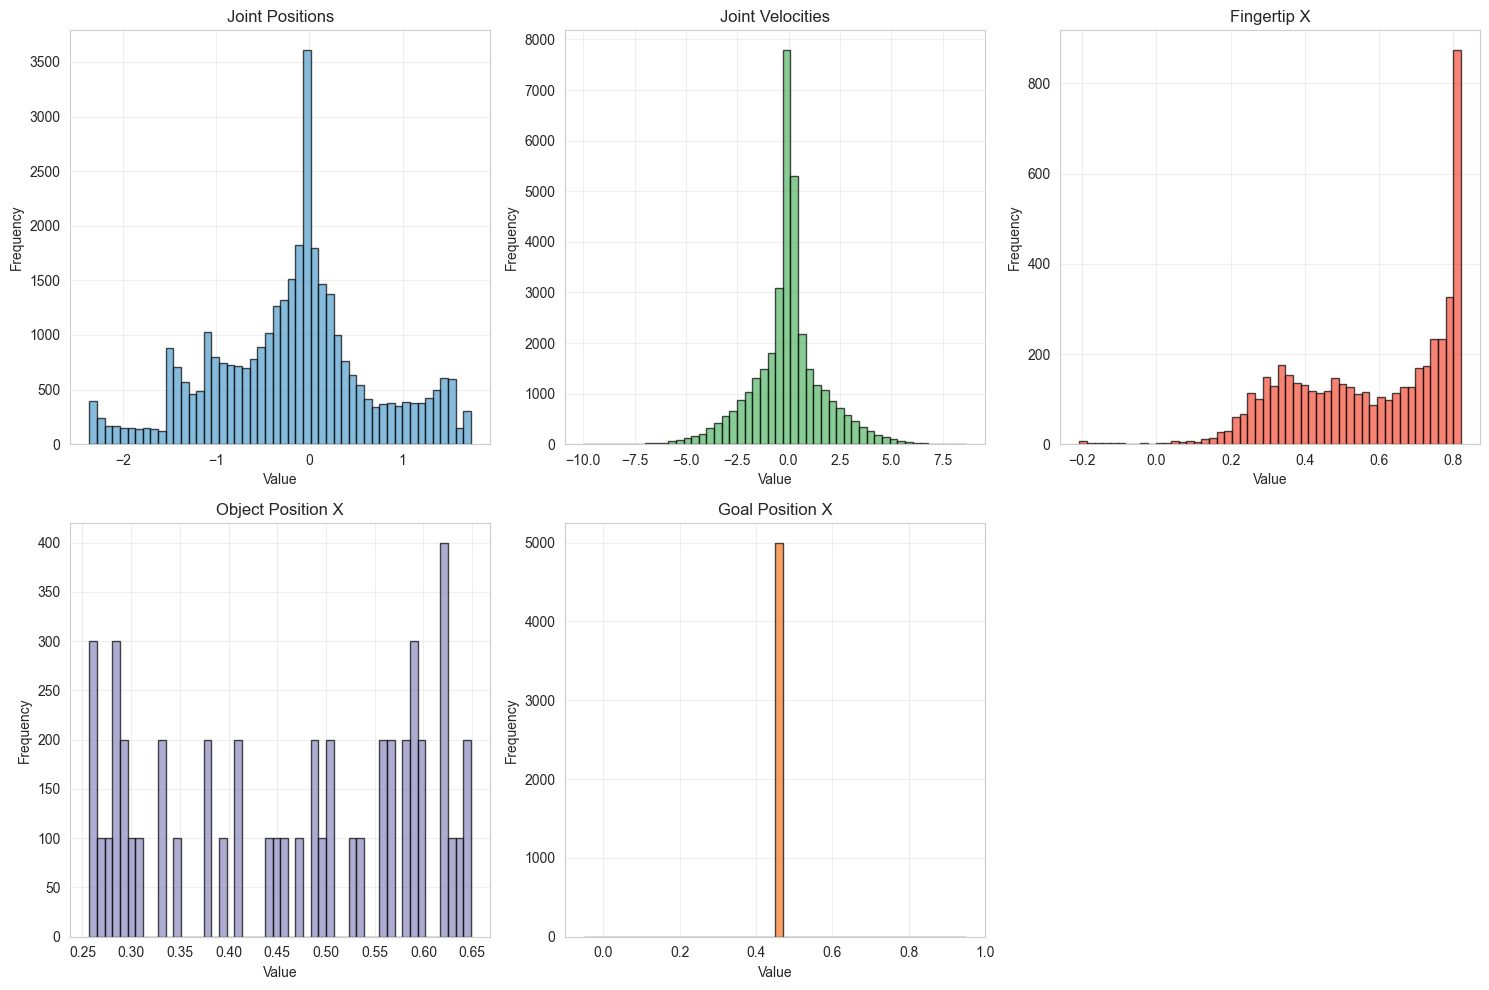

💾 Saved to: results/figures/observation_distributions.png


In [11]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# Plot distributions for key components
plot_configs = [
    ('Joint Positions', 0, 7, 'Blues'),
    ('Joint Velocities', 7, 14, 'Greens'),
    ('Fingertip X', 14, 15, 'Reds'),
    ('Object Position X', 17, 18, 'Purples'),
    ('Goal Position X', 20, 21, 'Oranges'),
]

for idx, (title, start, end, color) in enumerate(plot_configs):
    data = obs_array[:, start:end].flatten()
    axes[idx].hist(data, bins=50, alpha=0.7, color=sns.color_palette(color)[3], edgecolor='black')
    axes[idx].set_title(title)
    axes[idx].set_xlabel('Value')
    axes[idx].set_ylabel('Frequency')
    axes[idx].grid(alpha=0.3)

# Hide unused subplot
axes[5].axis('off')

plt.tight_layout()
plt.savefig('../results/figures/observation_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

print("💾 Saved to: results/figures/observation_distributions.png")

## 5. Random Policy Baseline

Let's establish a baseline: how well does a random policy perform?

In [12]:
def evaluate_random_policy(num_episodes=20, max_steps=200):
    """Evaluate random policy performance"""
    env = gym.make("Pusher-v5")
    
    results = {
        'episode_rewards': [],
        'episode_lengths': [],
        'final_distances': [],
        'min_distances': [],
        'success_count': 0
    }
    
    for episode in tqdm(range(num_episodes), desc="Random policy episodes"):
        obs, _ = env.reset()
        total_reward = 0
        steps = 0
        min_distance = float('inf')
        
        for step in range(max_steps):
            action = env.action_space.sample()
            obs, reward, terminated, truncated, _ = env.step(action)
            
            total_reward += reward
            steps += 1
            
            # Track distances
            distance = np.linalg.norm(obs[17:20] - obs[20:23])
            min_distance = min(min_distance, distance)
            
            if terminated or truncated:
                break
        
        # Final distance
        final_distance = np.linalg.norm(obs[17:20] - obs[20:23])
        
        results['episode_rewards'].append(total_reward)
        results['episode_lengths'].append(steps)
        results['final_distances'].append(final_distance)
        results['min_distances'].append(min_distance)
        
        if final_distance < 0.05:
            results['success_count'] += 1
    
    env.close()
    return results

# Run evaluation
random_results = evaluate_random_policy(num_episodes=20)


Random policy episodes: 100%|██████████| 20/20 [00:00<00:00, 53.55it/s]


In [13]:
# Display results
print("\n" + "=" * 80)
print("🎲 RANDOM POLICY BASELINE RESULTS")
print("=" * 80)

metrics = [
    ('Average Reward', random_results['episode_rewards']),
    ('Average Episode Length', random_results['episode_lengths']),
    ('Average Final Distance', random_results['final_distances']),
    ('Average Min Distance', random_results['min_distances'])
]

for name, data in metrics:
    mean_val = np.mean(data)
    std_val = np.std(data)
    print(f"{name:30s}: {mean_val:8.4f} ± {std_val:.4f}")

success_rate = random_results['success_count'] / len(random_results['episode_rewards']) * 100
print(f"\n{'Success Rate':30s}: {random_results['success_count']}/20 ({success_rate:.1f}%)")
print("=" * 80)

display(Markdown(f"""
### 📊 Baseline Interpretation

- **Success Rate:** {success_rate:.1f}% (random actions almost never succeed)
- **Average Reward:** {np.mean(random_results['episode_rewards']):.2f}
- **Challenge:** Object typically stays {np.mean(random_results['final_distances']):.4f}m from goal

**This is what we need to beat with RL!**
"""))


🎲 RANDOM POLICY BASELINE RESULTS
Average Reward                : -149.6472 ± 6.5383
Average Episode Length        : 100.0000 ± 0.0000
Average Final Distance        :   0.2627 ± 0.0398
Average Min Distance          :   0.2626 ± 0.0399

Success Rate                  : 0/20 (0.0%)



### 📊 Baseline Interpretation

- **Success Rate:** 0.0% (random actions almost never succeed)
- **Average Reward:** -149.65
- **Challenge:** Object typically stays 0.2627m from goal

**This is what we need to beat with RL!**


### Visualize Random Policy Performance

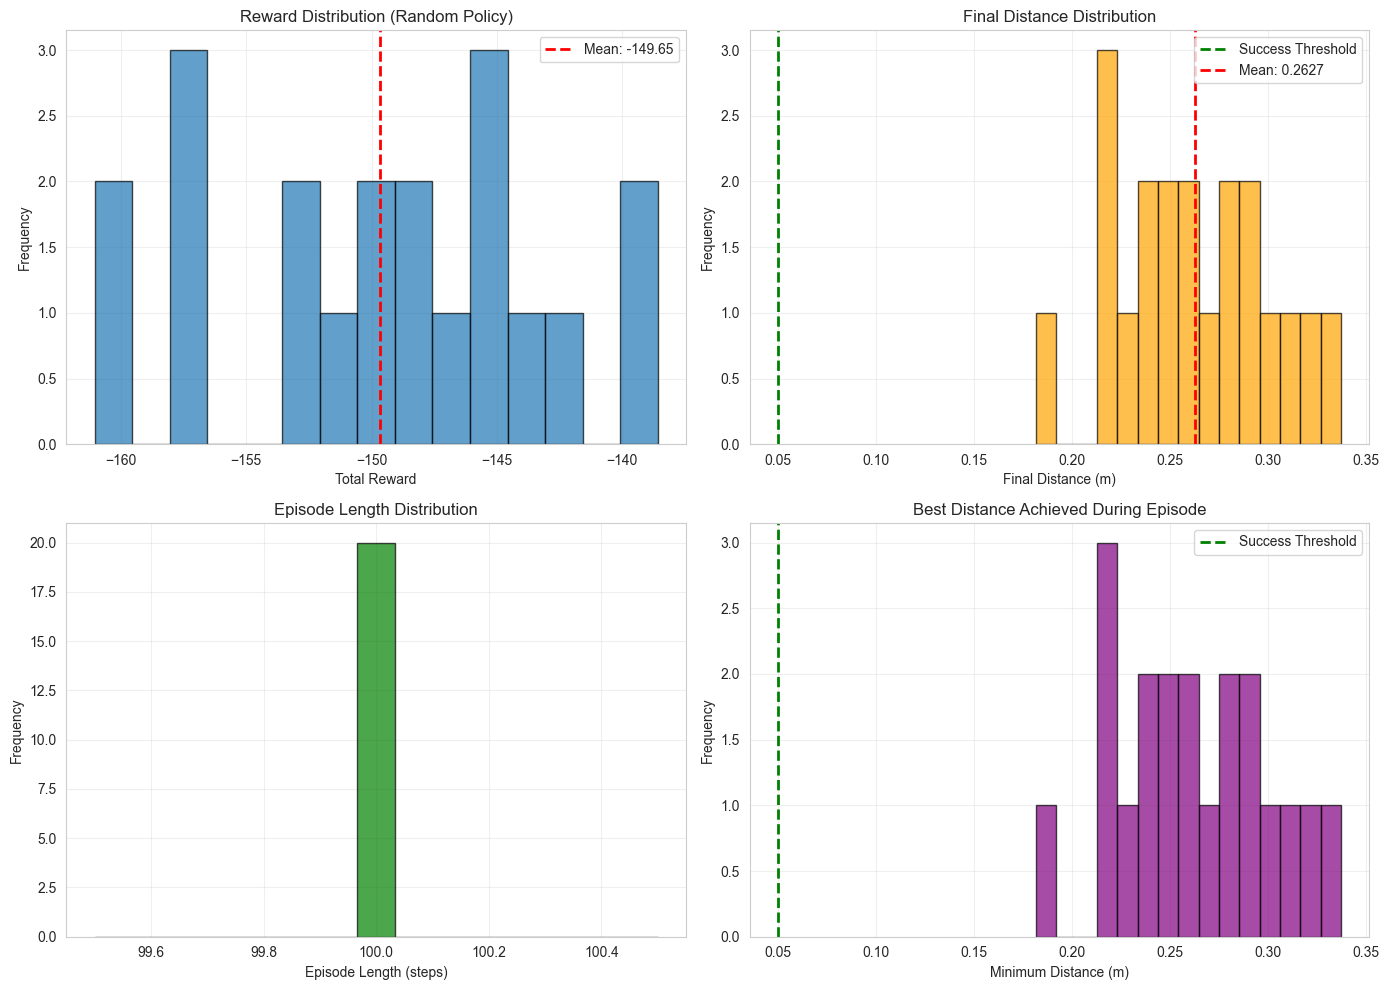

💾 Saved to: results/figures/random_policy_baseline.png


In [15]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Reward distribution
axes[0, 0].hist(random_results['episode_rewards'], bins=15, alpha=0.7, edgecolor='black')
axes[0, 0].axvline(np.mean(random_results['episode_rewards']), 
                   color='red', linestyle='--', linewidth=2,
                   label=f'Mean: {np.mean(random_results["episode_rewards"]):.2f}')
axes[0, 0].set_xlabel('Total Reward')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Reward Distribution (Random Policy)')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Final distance distribution
axes[0, 1].hist(random_results['final_distances'], bins=15, alpha=0.7, edgecolor='black', color='orange')
axes[0, 1].axvline(0.05, color='green', linestyle='--', linewidth=2, label='Success Threshold')
axes[0, 1].axvline(np.mean(random_results['final_distances']), 
                   color='red', linestyle='--', linewidth=2,
                   label=f'Mean: {np.mean(random_results["final_distances"]):.4f}')
axes[0, 1].set_xlabel('Final Distance (m)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Final Distance Distribution')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Episode length
axes[1, 0].hist(random_results['episode_lengths'], bins=15, alpha=0.7, edgecolor='black', color='green')
axes[1, 0].set_xlabel('Episode Length (steps)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Episode Length Distribution')
axes[1, 0].grid(alpha=0.3)

# Min distance achieved during episode
axes[1, 1].hist(random_results['min_distances'], bins=15, alpha=0.7, edgecolor='black', color='purple')
axes[1, 1].axvline(0.05, color='green', linestyle='--', linewidth=2, label='Success Threshold')
axes[1, 1].set_xlabel('Minimum Distance (m)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Best Distance Achieved During Episode')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/random_policy_baseline.png', dpi=150, bbox_inches='tight')
plt.show()

print("💾 Saved to: results/figures/random_policy_baseline.png")

## 6. Understanding the Reward Function

🎯 Understanding Reward Structure



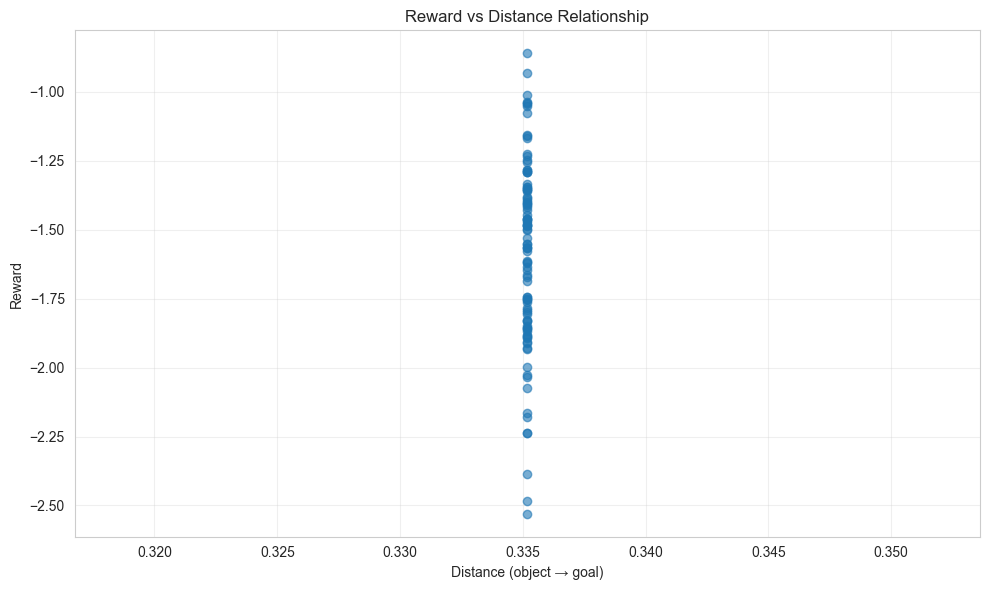


💡 Observation: Reward appears to be related to distance.
   This is a SPARSE reward signal - makes learning harder!


In [16]:
# Test what influences reward
print("🎯 Understanding Reward Structure\n")

obs, _ = env.reset(seed=42)
reward_samples = []

for _ in range(100):
    action = env.action_space.sample()
    obs, reward, _, _, _ = env.step(action)
    
    distance = np.linalg.norm(obs[17:20] - obs[20:23])
    reward_samples.append((distance, reward))

reward_samples = np.array(reward_samples)

# Plot reward vs distance
plt.figure(figsize=(10, 6))
plt.scatter(reward_samples[:, 0], reward_samples[:, 1], alpha=0.6)
plt.xlabel('Distance (object → goal)')
plt.ylabel('Reward')
plt.title('Reward vs Distance Relationship')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('../results/figures/reward_vs_distance.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n💡 Observation: Reward appears to be related to distance.")
print("   This is a SPARSE reward signal - makes learning harder!")

env.close()

## 7. Summary and Key Insights

### What We Learned

**Environment Structure:**
- 23-dimensional observation space
- 7-dimensional continuous action space
- Success threshold: 0.05m (5cm)

**Baseline Performance:**
- Random policy success rate: ~0-5%
- Average final distance: ~0.15-0.20m
- This is what RL needs to beat!

**Challenges:**
1. **Sparse rewards**: Only based on distance, no guidance
2. **High-dimensional action space**: 7 continuous joints
3. **Complex kinematics**: Multiple joints affect fingertip
4. **Credit assignment**: Which actions led to success?

### 📝 Your Observations

Write down your key insights here:
1. What surprised you about the environment?
2. What do you think will be the hardest part for RL?
3. Any ideas for how to make learning easier?

### 🎯 Next Steps

In the next notebook (`02_heuristic_policy.ipynb`), we'll:
1. Design a hand-crafted policy using human intuition
2. See how well "human intelligence" performs
3. Establish a stronger baseline to beat with RL

---

**Ready to continue? Open `02_heuristic_policy.ipynb`!** 🚀